In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from hydra import compose, initialize
from pathlib import Path
import os

from retailsynth import REPO_ROOT_DIR
from retailsynth.base_config import load_config_store
from scenario_utils.plot_aggregated_stats import (
    plot_discount_state_proportion,
    plot_discount_distribution,
    get_discount_summary_df,
    plot_price_distribution,
    plot_purchase_summary_for_all_customers,
)
from scenario_utils.segment_analysis import (
    generate_segment_report_from_trx_for_one_policy,
    generate_segment_report_from_synthesizer_for_one_policy,
    Loader,
    plot_purchase_summary_for_segments,
)

%load_ext autoreload
%autoreload 2

In [3]:
!cd {REPO_ROOT_DIR} && python {REPO_ROOT_DIR}/analysis_workflow/3_scenario_analysis/run_scenarios.py

/Users/43669/repos/retmar
/Users/43669/repos/retmar/src/retailsynth/utils/dataset_viz.py:102: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(
/Users/43669/repos/retmar/src/retailsynth/utils/dataset_viz.py:111: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(
/Users/43669/repos/retmar/analysis_workflow/3_scenario_analysis/run_scenarios.py:33: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(
[2023-12-22 08:59:37,470][root][INFO] - Running data synthesis
[2023-12-22 08:59:37,530][jax._src.xla_bridge][INFO] - Unable to initialize backend 'cuda': 
[2023-12-22 08:59:37,531][jax._src.xla_bridge][INFO] - Unable to initialize backend 'rocm': module 

# Scenario Analysis - Discount Depth and Frequency

This notebook focuses on analyzing the impact of pricing policies, specifically the depth and frequency of discounts, on customer purchasing behavior. The primary goal here is to produce synthetic transaction data under a range of discount policies and then examine the resulting changes in purchasing patterns. 

In [7]:
output_path = Path(REPO_ROOT_DIR, "analysis_workflow/3_scenario_analysis/outputs")
os.chdir(output_path)
os.getcwd()

'/Users/43669/repos/retmar/analysis_workflow/3_scenario_analysis/outputs'

In [8]:
with initialize(version_base=None, config_path="cfg"):
    load_config_store()
    cfg = compose(config_name="synthetic_dataset")

In [9]:
synthetic_data_loaders = {
    policy_name: Loader(
        policy_name=policy_name, data_path=Path(policy_name, cfg.paths.processed_data)
    )
    for policy_name in ["I", "II", "III", "IV", "V"]
}

## Description of Discount Policies

These pricing policies are structured around two key elements: discount depth and discount frequency. Discount depth pertains to the extent of reduction from the original price, spanning from a modest 5% discount to a substantial 50% price cut. By setting a maximum cap of 50%, we aim to align with common retail practices, safeguarding overall profitability.

Discount frequency refers to the percentage of weeks a product is offered at a discounted price and is set at 30% or 60%. 

By adjusting these parameters, we can create diverse discount strategies. In this analysis, we focus on five specific combinations of discount depth and frequency. We give an overview below, with the policies ordered by their time-averaged discount level.

In [10]:
labels = ["I", "II", "III", "IV", "V"]
synthesizers = [synthetic_data_loaders[name].synthesizer for name in labels]

discount_df = get_discount_summary_df(synthesizers, labels)
discount_df

,discount_frequency,discount_depth,discount_level,policy
0,0.6,0.05,0.030019,I
1,0.3,0.10,0.030004,II
2,0.6,0.25,0.149968,III
3,0.3,0.50,0.149950,IV
4,0.6,0.40,0.239909,V


We are interested in screening incremental effects of discount frequency and depth and so we create pairs of policies (I and II, III and IV) where the discount level is the same but frequency and depth differ.

Discount depth and frequency are dynamic and to understand the data further we show the marginal distributions of discount depth and prices and timeseries of the proportion of products in the discount state.

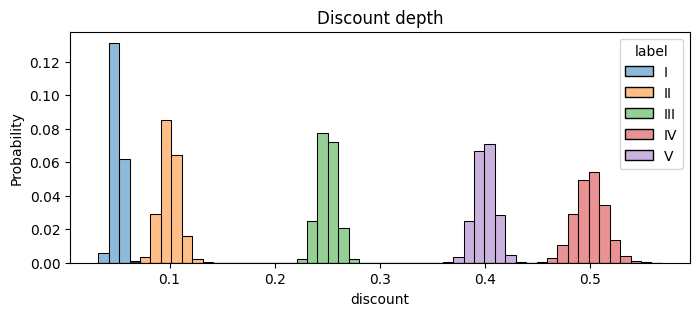

In [16]:
synthesizers = [
    synthetic_data_loaders[name].synthesizer for name in ["I", "II", "III", "IV", "V"]
]
labels = ["I", "II", "III", "IV", "V"]

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax = plot_discount_distribution(synthesizers, labels, ax=ax, binwidth=0.01)

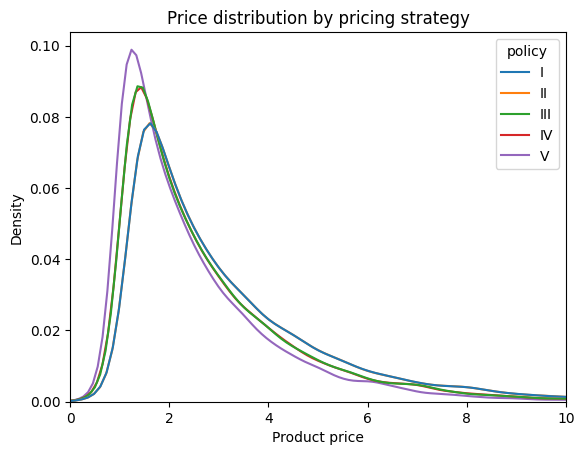

In [13]:
labels = ["I", "II", "III", "IV", "V"]
synthesizers = [synthetic_data_loaders[name].synthesizer for name in labels]

ax = plot_price_distribution(synthesizers, labels)

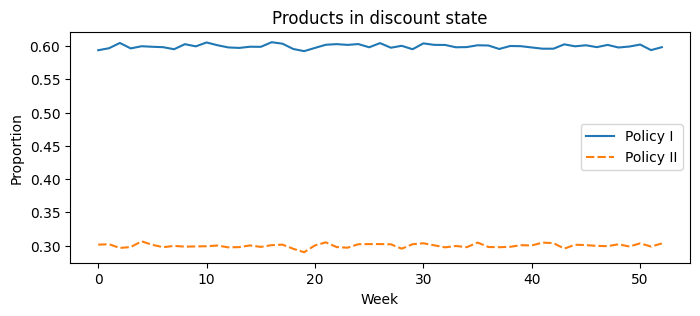

In [12]:
synthesizers = [synthetic_data_loaders[name].synthesizer for name in ["I", "II"]]
labels = ["Policy I", "Policy II"]

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax = plot_discount_state_proportion(synthesizers, labels, ax=ax)

## The Effect of Discount Policies on Purchasing Habits

Below we show key metrics averaged across all customers for the different policies. See the paper for a discussion of the results.

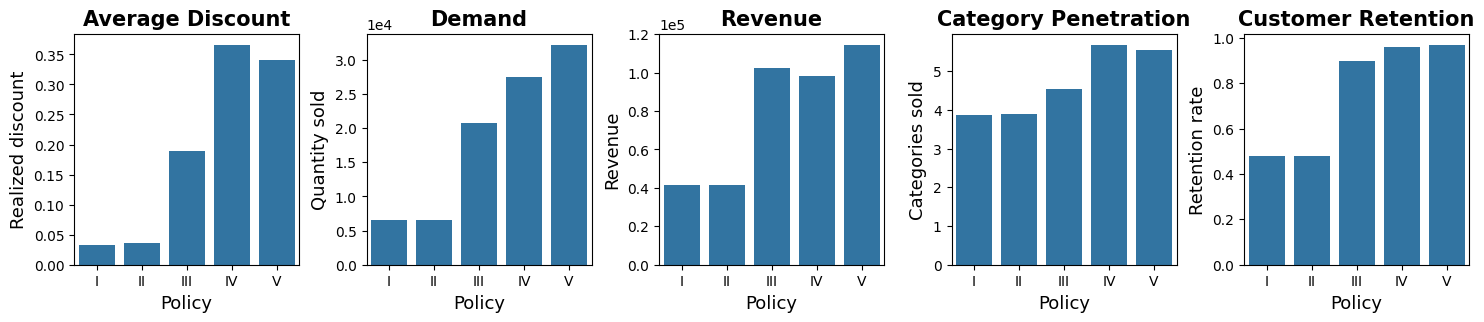

In [14]:
policy_plotting_order = ["I", "II", "III", "IV", "V"]

reports = []
for data_loader in synthetic_data_loaders.values():
    report = generate_segment_report_from_trx_for_one_policy(data_loader, n_segment=1)
    reports.append(report)
reports_for_all_population = pd.concat(reports)

fig_population, axes_population = plot_purchase_summary_for_all_customers(
    reports_for_all_population,
    policy_plotting_order=policy_plotting_order,
    row_size=18,
    column_size=3,
    label_args={"fontsize": 13},
    title_args={"fontsize": 15, "fontweight": "bold"},
)

## Segment Analysis Based on Price Sensitivity

Here we perform an analysis of customer segments analysis. The segments are determined by the customer's latent price sensitivity, as defined inside the synthesizer. We have: 

1. 'High sensitivity', who are highly reactive to price change; 
2. 'Medium sensitivity' moderately responsive, 
4. 'Low sensitivity' are the least swayed by price alterations.

To effectively understand the purchasing patterns of each segment, we examine the same key metrics as above as well as the price elasticities.

In [17]:
number_of_segment = 3
segment_names = ["1. High sensitivity", "2. Medium sensitivity", "3. Low sensitivity"]

elasticity_reports = []
for data_loader_name in ["I", "II", "IV", "III", "V"]:
    report = generate_segment_report_from_synthesizer_for_one_policy(
        synthetic_data_loaders[data_loader_name], number_of_segment, segment_names
    )
    elasticity_reports.append(report)
elasticity_reports = pd.concat(elasticity_reports)

In [18]:
elasticity_reports.groupby("segment")[["mean_utility_beta_w", "mean_elasticity"]].mean()

,mean_utility_beta_w,mean_elasticity
segment,,
1. High sensitivity,-15.804186,-15.673325
2. Medium sensitivity,-12.763257,-12.668922
3. Low sensitivity,-9.456924,-9.396544


In [19]:
number_of_segment = 3
segment_names = ["1. High sensitivity", "2. Medium sensitivity", "3. Low sensitivity"]

reports = []
for data_loader_name in ["I", "II", "III", "IV", "V"]:
    report = generate_segment_report_from_trx_for_one_policy(
        synthetic_data_loaders[data_loader_name], number_of_segment, segment_names
    )
    reports.append(report)
reports_for_segments = pd.concat(reports)

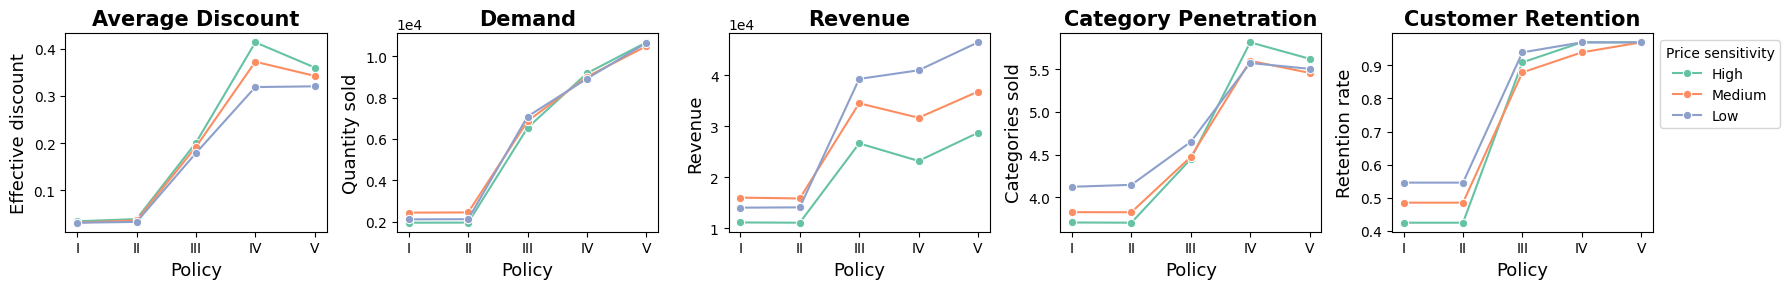

In [20]:
colors = sns.color_palette("Set2", n_colors=number_of_segment)
palette = dict(zip(segment_names, colors))

fig_segment, axes_segment = plot_purchase_summary_for_segments(
    reports_for_segments,
    palette=palette,
    row_size=18,
    column_size=3,
    label_args={"fontsize": 13},
    title_args={"fontsize": 15, "fontweight": "bold"},
    legend_args={
        "bbox_to_anchor": (1, 1),
    },
)
plt.tight_layout()

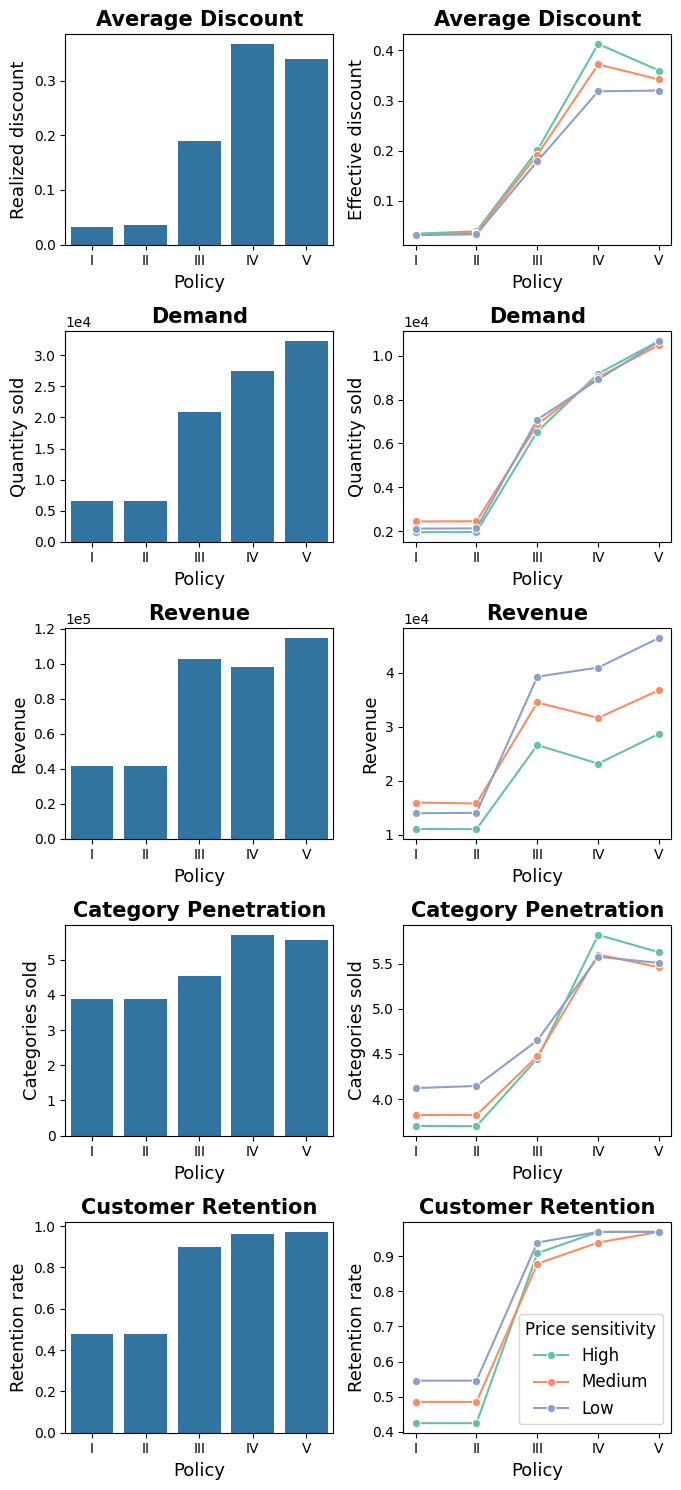

In [20]:
# store a local copy of the panel
fig_combined, axes = plt.subplots(
    nrows=5, ncols=2, figsize=(7, 15)
)  # You can adjust the number of rows and columns as needed
_, _ = plot_purchase_summary_for_all_customers(
    reports_for_all_population,
    policy_plotting_order=policy_plotting_order,
    axes=axes[:, 0],
    label_args={"fontsize": 13},
    title_args={"fontsize": 15, "fontweight": "bold"},
)
_, _ = plot_purchase_summary_for_segments(
    reports_for_segments,
    palette=palette,
    axes=axes[:, 1],
    label_args={"fontsize": 13},
    title_args={"fontsize": 15, "fontweight": "bold"},
    legend_args={"fontsize": 12, "title_fontsize": 12},
)

plt.tight_layout()
fig_combined.savefig("scenario_analysis_panel.png", dpi=300, bbox_inches="tight")